In [11]:
import glob

import numpy as np

from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import optimizers
from keras import regularizers

import matplotlib.pyplot as plt

In [2]:
LABELS = ['apple', 'pear']
TRAIN_DIR = 'images_/train'
VAL_DIR = 'images_/val'
TEST_DIR = 'images_/test'

In [3]:
# from glob import glob
# from sklearn.model_selection import train_test_split


# !mkdir $VAL_DIR

# for l in LABELS:
#     images = glob('%s/%s/*' % (TRAIN_DIR, l))
#     images_train, images_val = train_test_split(images, test_size=0.2)

#     !mkdir $VAL_DIR/$l
#     files = ' '.join(images_val)
#     !mv -t $VAL_DIR/$l $files

In [4]:
def plot_history(history, params=['loss', 'acc']):
    for param in params:
        plt.plot(history.history[param], label='train')
        if 'val_%s' % param in history.history.keys():
            plt.plot(history.history['val_%s' % param], label='test')
        plt.xlabel('epoch')
        plt.ylabel(param)
        plt.title(param.capitalize())
        plt.legend()
        plt.show()

In [5]:
def predict_image(image_path, model, img_size, preproc_func, decode_func):
    image = load_img(image_path)
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    
    image = image.resize(img_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preproc_func(image)
    
    pred = model.predict(image)
    pred = decode_func(pred, top=3)
    title = '\n'.join(['%s (%0.2f%%)' % (p[1].capitalize(), 100 * p[2]) for p in pred[0]])
    
    plt.title(title)
    plt.show()

In [6]:
def predict(model, img):
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    class_probs = model.predict(x)[0]
    labels = [LABELS[i] for i in np.argsort(class_probs)[::-1][:3]]
    confs = np.sort(class_probs)[::-1][:3]
    
    return labels, 100 * confs


def predict_test_images(model):
    test_images = glob.glob('%s/*' % TEST_DIR)
    h, w = np.ceil(len(test_images) / 3), 3
    
    plt.figure(figsize=(5 * w, 5 * h))

    for i, img_file in enumerate(test_images):
        plt.subplot(h, w, i + 1)
        img = load_img(img_file, target_size=(HEIGHT, WIDTH))
        labels, confs = predict(model, img)
        plt.imshow(np.asarray(img))
        title = '\n'.join(['%s (%0.2f%%)' % (label, conf) for label, conf in zip(labels, confs)])
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [7]:
def show_most_confident_predictions(ds, model, h=5, w=5):
    n_img = min(h * w, ds.shape[0])
    
    preds = model.predict(ds, verbose=0)
    most_conf = np.argsort(np.max(preds, axis=1))[-n_img::-1]
    x = ds[most_conf]
    preds = [preds[i] for i in most_conf]
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i in range(n_img):
        plt.subplot(h, w, i + 1)
        image = x[i].reshape(W, H, n_channels)
        plt.imshow(image)
        title = '%s\n%0.2f%%' % (LABELS[np.argmax(preds[i])], 100 * np.max(preds[i]))
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [8]:
incv3 = InceptionV3(weights='imagenet', include_top=True)
incv3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

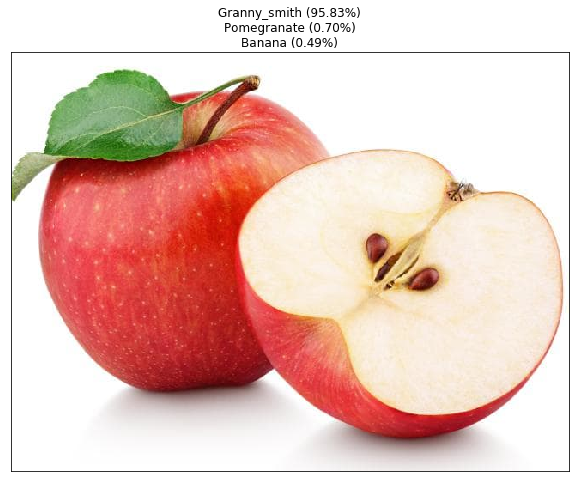

In [9]:
predict_image('images_/test/test_0002.jpg', incv3, (299, 299), 
              preprocess_input, 
              decode_predictions)

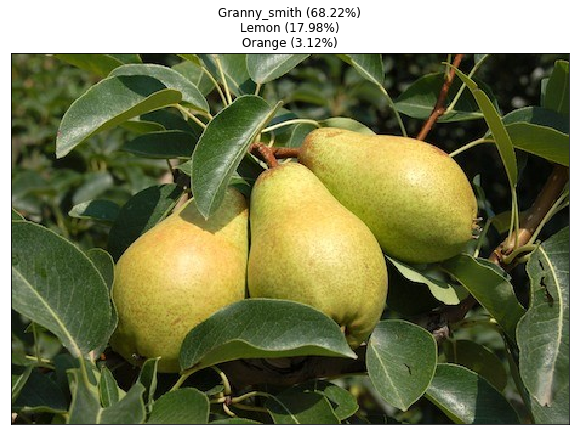

In [10]:
predict_image('images_/test/test_0006.jpg', incv3, (299, 299), 
              preprocess_input, 
              decode_predictions)

In [11]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output

x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

predictions = Dense(len(LABELS), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer=optimizers.rmsprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [34]:
WIDTH = 150
HEIGHT = 150
BATCH_SIZE = 16

In [35]:
img_gen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

img_gen_validation = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = img_gen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')    
validation_generator = img_gen_validation.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 1322 images belonging to 2 classes.
Found 334 images belonging to 2 classes.


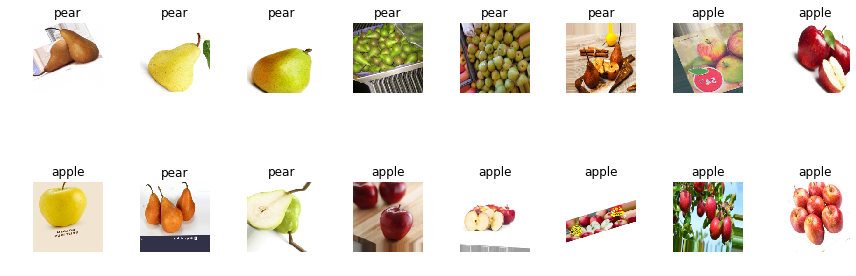

In [36]:
x_batch, y_batch = next(train_generator)
h, w = 4, 8

plt.figure(figsize=(12, 9))
for i, (img, class_probs) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(h, w, i + 1)
    plt.imshow((img + 1) / 2)
    plt.title(LABELS[np.argmax(class_probs)])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
EPOCHS = 20
tb = TensorBoard(log_dir="logs", write_graph=True, write_images=True)

In [17]:
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[tb],
    steps_per_epoch=2 * len(train_generator),
    validation_steps=len(validation_generator))

Epoch 1/20


/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/lib/python3/dist-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


166/166 [==============================] - 183s 1s/step - loss: 1.7028 - acc: 0.6202 - val_loss: 2.0957 - val_acc: 0.6617
Epoch 2/20
166/166 [==============================] - 183s 1s/step - loss: 1.5134 - acc: 0.7032 - val_loss: 2.2836 - val_acc: 0.6856
Epoch 3/20
166/166 [==============================] - 165s 996ms/step - loss: 1.4634 - acc: 0.7248 - val_loss: 2.3106 - val_acc: 0.6796
Epoch 4/20
166/166 [==============================] - 165s 993ms/step - loss: 1.3558 - acc: 0.7585 - val_loss: 2.4033 - val_acc: 0.6707
Epoch 5/20
166/166 [==============================] - 165s 996ms/step - loss: 1.3529 - acc: 0.7617 - val_loss: 2.3774 - val_acc: 0.6677
Epoch 6/20
166/166 [==============================] - 166s 1s/step - loss: 1.3261 - acc: 0.7667 - val_loss: 2.3956 - val_acc: 0.6826
Epoch 7/20
166/166 [==============================] - 180s 1s/step - loss: 1.2732 - acc: 0.7791 - val_loss: 2.0171 - val_acc: 0.7365
Epoch 8/20
166/166 [==============================] - 165s 997ms/step -

In [18]:
model.save('bn_head_20_epochs.hdf5')

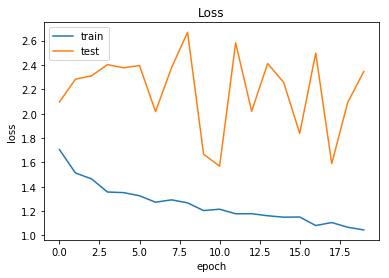

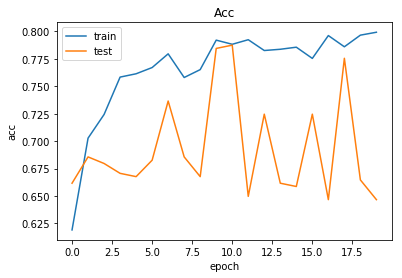

In [19]:
plot_history(history)

In [12]:
model = load_model('bn_head_20_epochs.hdf5')

In [25]:
score = model.evaluate_generator(validation_generator, steps=100)

In [26]:
acc = 100 * score[1]
print('Model val accuracy: %0.3f%%' % acc)

Model val accuracy: 64.969%


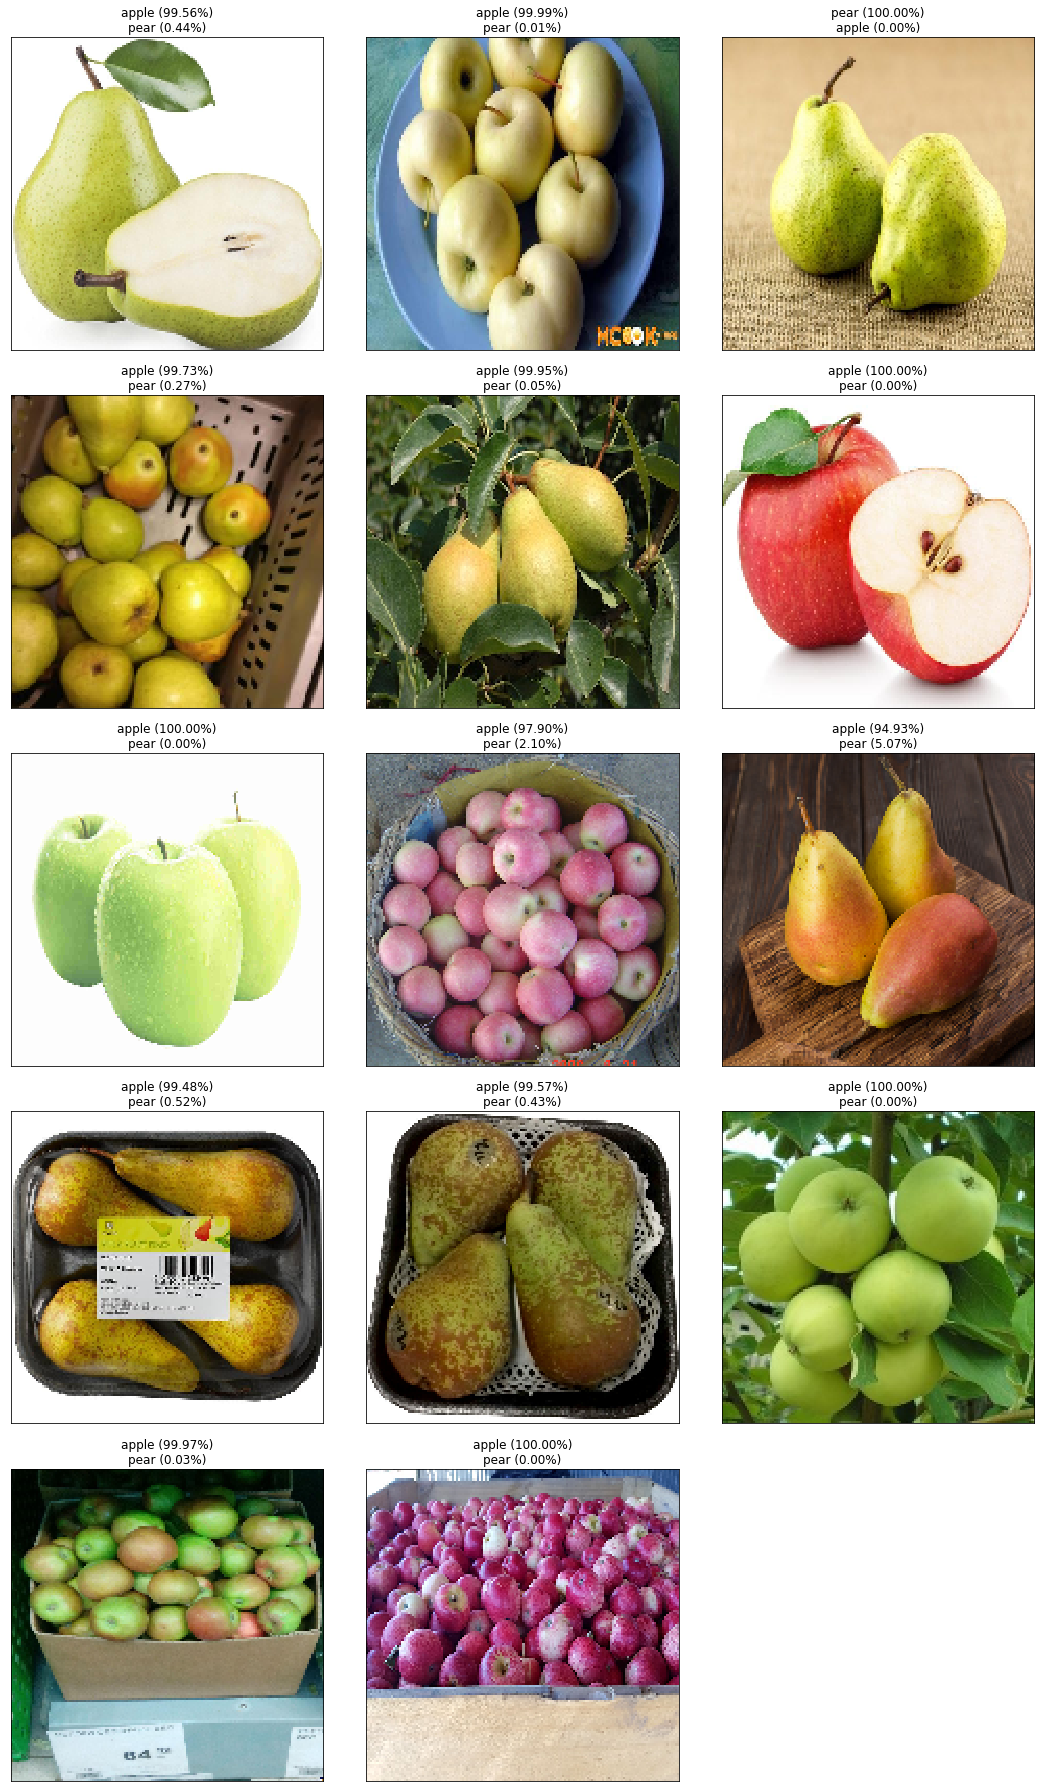

In [27]:
predict_test_images(model)

In [28]:
tb = TensorBoard(log_dir="logs", write_graph=True, write_images=True)

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=5e-5, momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [37]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=2 * len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[tb])

Epoch 1/20


/usr/lib/python3/dist-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


165/166 [============================>.] - ETA: 1s - loss: 1.0485 - acc: 0.7992

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


166/166 [==============================] - 288s 2s/step - loss: 1.0472 - acc: 0.7997 - val_loss: 1.5026 - val_acc: 0.7814
Epoch 2/20
166/166 [==============================] - 283s 2s/step - loss: 1.0082 - acc: 0.8113 - val_loss: 1.5467 - val_acc: 0.7665
Epoch 3/20
166/166 [==============================] - 277s 2s/step - loss: 0.9912 - acc: 0.8258 - val_loss: 1.3739 - val_acc: 0.7964
Epoch 4/20
166/166 [==============================] - 230s 1s/step - loss: 0.9798 - acc: 0.8191 - val_loss: 1.4304 - val_acc: 0.7994
Epoch 5/20
166/166 [==============================] - 239s 1s/step - loss: 0.9911 - acc: 0.8218 - val_loss: 1.3288 - val_acc: 0.8024
Epoch 6/20
166/166 [==============================] - 281s 2s/step - loss: 0.9760 - acc: 0.8261 - val_loss: 1.3554 - val_acc: 0.8024
Epoch 7/20
166/166 [==============================] - 238s 1s/step - loss: 0.9470 - acc: 0.8440 - val_loss: 1.3825 - val_acc: 0.8024
Epoch 8/20
166/166 [==============================] - 239s 1s/step - loss: 0.941

In [38]:
model.save('bn_unfreezed_head_20_epochs.hdf5')

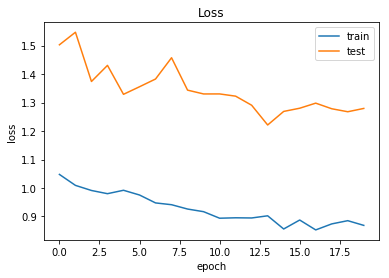

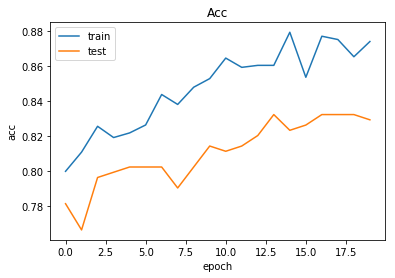

In [39]:
plot_history(history)

In [40]:
score = model.evaluate_generator(validation_generator, steps=len(validation_generator))

In [41]:
acc = 100 * score[1]
print('Model val accuracy: %0.3f%%' % acc)

Model val accuracy: 83.832%


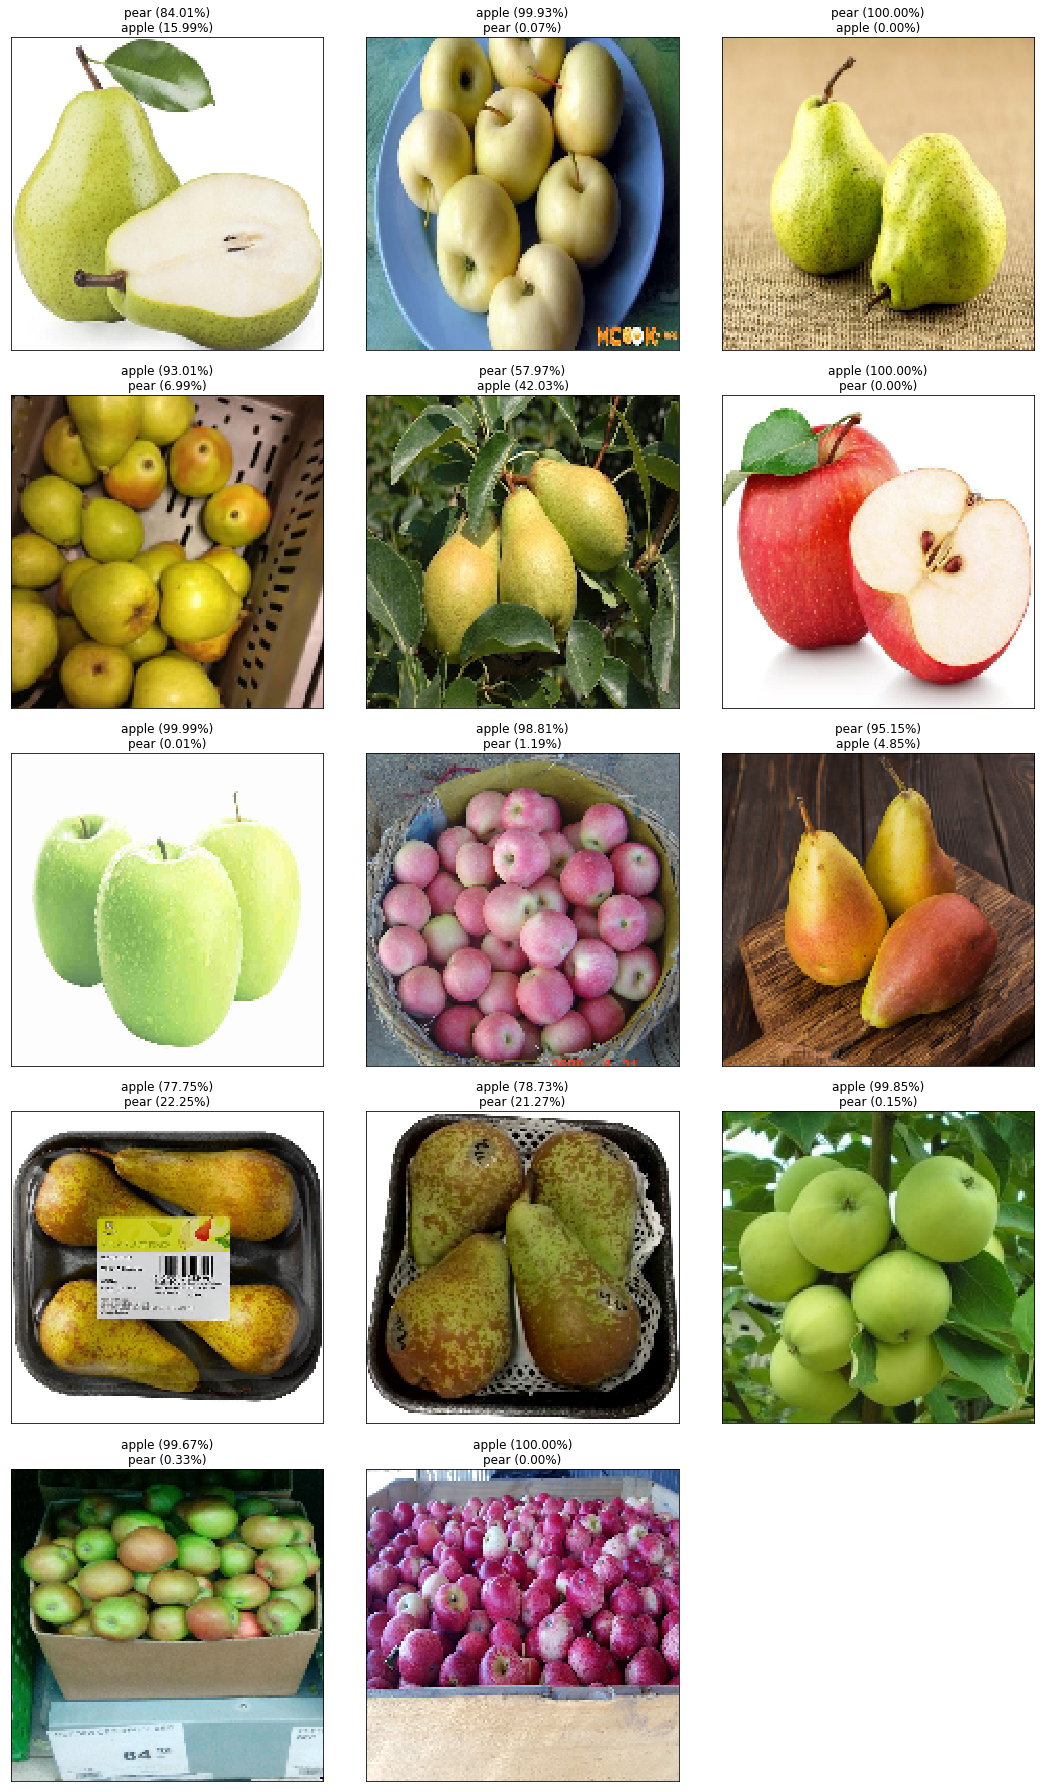

In [42]:
predict_test_images(model)

In [47]:
show_most_confident_predictions(x_val, model)

NameError: name 'x_val' is not defined